In [ ]:
# ==============================================================
# 0.  IMPORTS, CONSTANTES, INTERFACES BÁSICAS
# ==============================================================
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from tqdm import tqdm


class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """

    @property
    @abstractmethod
    def dim(self) -> int:
        """
        Returns:
            - Dimensionality of the distribution
        """
        pass

    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """


# ==============================================================
# 1.  DATASET  (x,t)→u   —  funciona como Dataset **y** Sampleable
# ==============================================================
class WaveTensorDataset(Sampleable, torch.utils.data.Dataset):
    """
    Cada elemento es tensor shape (3,)  =  [u , x , t]
    """

    def __init__(self, pt_file, device=DEVICE):
        d = torch.load(pt_file, map_location=device)
        xx, tt = torch.meshgrid(d["x"], d["t"], indexing="ij")
        z = torch.stack([xx, tt], dim=-1).reshape(-1, 2).float()
        u = d["u"].T.reshape(-1, 1).float()
        self.data = torch.cat([u, z], dim=1)  # (N,3)
        self._dim = 3

    # --- Dataset API ---
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        return self.data[i]

    # --- Sampleable API ---
    @property
    def dim(self):
        return self._dim

    def sample(self, n):  # usa randint para compatibilidad previa
        idx = torch.randint(0, len(self), (n,), device=self.data.device)
        return self.data[idx]


# ==============================================================
# 2.  SCHEDULE α, β (sin cambios)
# ==============================================================
class Alpha:
    def __call__(self, t):
        return torch.exp(-0.5 * t)

    def dt(self, t):
        return -0.5 * torch.exp(-0.5 * t)


class Beta:
    def __call__(self, t):
        return torch.sqrt(1.0 - torch.exp(-t))

    def dt(self, t):
        return 0.5 * torch.exp(-t) / (self.__call__(t) + 1e-8)


alpha, beta = Alpha(), Beta()


# ==============================================================
# 3.  MLP para el vector-field (sin cambios)
# ==============================================================
def mlp(sizes, act=nn.SiLU):
    layers = []
    L = len(sizes) - 1
    for i in range(L):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < L - 1:
            layers.append(act())
    return nn.Sequential(*layers)


class VectorField(nn.Module):
    def __init__(self):
        super().__init__()

    def __init__(self, hidden=[100, 100, 100, 100]):
        super().__init__()
        self.net = mlp([1 + 2 + 1] + hidden + [1])

    def forward(self, u, z, t):
        return self.net(torch.cat([u, z, t], dim=-1))


# ==============================================================
# 4.  ENTRENAMIENTO  —  ahora con DataLoader
# ==============================================================
def train_flow(pt_path: Path):
    ds = WaveTensorDataset(pt_path)
    loader = DataLoader(ds, batch_size=BATCH, shuffle=True)
    it = iter(loader)

    net = VectorField().to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=LR)

    for s in tqdm(range(1, STEPS + 1)):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)
        batch = batch.to(DEVICE)  # (bs,3)
        u_star, z = batch[:, :1], batch[:, 1:]  # (bs,1) , (bs,2)

        t = torch.rand_like(u_star) * (1 - 2 * EPS_T) + EPS_T
        eps = torch.randn_like(u_star)
        u_t = alpha(t) * u_star + beta(t) * eps

        A = alpha.dt(t) - (beta.dt(t) / beta(t)) * alpha(t)
        B = beta.dt(t) / beta(t)
        target = A * u_star + B * u_t

        pred = net(u_t, z, t)
        loss = F.mse_loss(pred, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if s % 1000 == 0:
            print(f"[{s:5d}/{STEPS}]  loss={loss.item():.3e}")

    # --- carpeta donde guardar los modelos ---
    model_dir = pt_path.parent / "flow_models"
    model_dir.mkdir(exist_ok=True)

    # nombre del archivo  *.fm.pt  conservando el k
    model_file = model_dir / pt_path.with_suffix(".fm.pt").name

    torch.save(net.state_dict(), model_file)
    print(f"✅  modelo guardado → {model_file}")
    return net


# ==============================================================
# 5.  ODE + Euler para reconstrucción  (sin cambios esenciales)
# ==============================================================
class ODE(nn.Module):
    def drift_coefficient(self, u, t): ...
class LearnedODE(ODE):
    def __init__(self, net, z):
        super().__init__()
        self.net, self.z = net, z

    def drift_coefficient(self, u, t):
        return self.net(u, self.z, t)


class Simulator:
    def step(self, u, t, h): ...
    @torch.no_grad()
    def simulate(self, u, ts):
        for k in range(ts.shape[1] - 1):
            t, h = ts[:, k], ts[:, k + 1] - ts[:, k]
            u = self.step(u, t, h)
        return u


class EulerSimulator(Simulator):
    def __init__(self, ode):
        self.ode = ode

    def step(self, u, t, h):
        return u + self.ode.drift_coefficient(u, t) * h


class HeunSimulator(Simulator):
    def __init__(self, ode):
        self.ode = ode

    def step(self, u, t, h):
        k1 = self.ode.drift_coefficient(u, t)
        k2 = self.ode.drift_coefficient(u + k1 * h, t + h)
        return u + 0.5 * (k1 + k2) * h


# ...
# pred, true = reconstruct(pt, fm, N=301, steps=8000)


def reconstruct(pt_path, model_path, N=301, steps=4000):
    d = torch.load(pt_path, map_location=DEVICE)
    xg = torch.linspace(0, d["x"][-1], N, device=DEVICE)
    tg = torch.linspace(0, d["t"][-1], N, device=DEVICE)
    xx, tt = torch.meshgrid(xg, tg, indexing="ij")
    z_grid = torch.stack([xx, tt], dim=-1).reshape(-1, 2).float()
    M = z_grid.size(0)

    net = VectorField().to(DEVICE)
    net.load_state_dict(torch.load(model_path, map_location=DEVICE))
    ode = LearnedODE(net.eval(), z_grid)
    # solver = EulerSimulator(ode)
    solver = HeunSimulator(ode)

    u1 = torch.randn(M, 1, device=DEVICE)
    ts = torch.linspace(1.0, 0.0, steps + 1, device=DEVICE).expand(M, -1).unsqueeze(-1)
    u0 = solver.simulate(u1, ts)
    return u0.view(N, N).cpu(), d["u"]

In [29]:
# Constantes y parámetros
DEVICE, EPS_T, LR = (
    "cuda" if torch.cuda.is_available() else "cpu",
    1e-3,
    1e-3,
)
STEPS, BATCH = 10000, 64
print(f"🟢 Usando dispositivo: {DEVICE}")
root = Path("wave_solutions")
for f in root.glob("u_wave_k*.pt"):
    print(f"🟢 Entrenando {f.name}")
    train_flow(f)

/tmp/ipykernel_3847249/565320740.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_file, map_location=device)


🟢 Usando dispositivo: cuda
🟢 Entrenando u_wave_k1.pt


  0%|          | 0/10000 [00:00<?, ?it/s]

 11%|█         | 1113/10000 [00:01<00:15, 579.18it/s]

[ 1000/10000]  loss=2.172e-01


 21%|██        | 2106/10000 [00:03<00:13, 573.16it/s]

[ 2000/10000]  loss=1.297e-01


 31%|███       | 3091/10000 [00:05<00:12, 568.05it/s]

[ 3000/10000]  loss=1.468e+00


 41%|████      | 4081/10000 [00:07<00:10, 566.17it/s]

[ 4000/10000]  loss=2.975e+00


 51%|█████     | 5075/10000 [00:08<00:08, 571.04it/s]

[ 5000/10000]  loss=2.187e-01


 61%|██████    | 6114/10000 [00:10<00:06, 575.71it/s]

[ 6000/10000]  loss=2.430e-02


 71%|███████   | 7105/10000 [00:12<00:04, 581.30it/s]

[ 7000/10000]  loss=4.299e-01


 81%|████████  | 8102/10000 [00:14<00:03, 562.77it/s]

[ 8000/10000]  loss=8.161e-02


 91%|█████████ | 9078/10000 [00:15<00:01, 566.41it/s]

[ 9000/10000]  loss=4.325e-02


100%|██████████| 10000/10000 [00:17<00:00, 571.87it/s]


[10000/10000]  loss=1.140e+00
✅  modelo guardado → wave_solutions/flow_models/u_wave_k1.fm.pt
🟢 Entrenando u_wave_k3.pt


 11%|█         | 1110/10000 [00:01<00:15, 563.07it/s]

[ 1000/10000]  loss=7.701e-01


 21%|██        | 2100/10000 [00:03<00:13, 576.22it/s]

[ 2000/10000]  loss=1.425e+00


 31%|███       | 3096/10000 [00:05<00:11, 576.94it/s]

[ 3000/10000]  loss=7.046e-01


 41%|████      | 4076/10000 [00:07<00:10, 554.14it/s]

[ 4000/10000]  loss=4.144e+00


 51%|█████     | 5101/10000 [00:08<00:08, 560.92it/s]

[ 5000/10000]  loss=8.274e-01


 61%|██████    | 6082/10000 [00:10<00:06, 568.98it/s]

[ 6000/10000]  loss=5.985e-01


 71%|███████   | 7068/10000 [00:12<00:05, 576.31it/s]

[ 7000/10000]  loss=6.188e-01


 81%|████████  | 8108/10000 [00:14<00:03, 569.55it/s]

[ 8000/10000]  loss=3.653e-01


 91%|█████████ | 9104/10000 [00:16<00:01, 578.60it/s]

[ 9000/10000]  loss=1.391e+00


100%|██████████| 10000/10000 [00:17<00:00, 569.42it/s]


[10000/10000]  loss=9.912e+00
✅  modelo guardado → wave_solutions/flow_models/u_wave_k3.fm.pt
🟢 Entrenando u_wave_k4.pt


 11%|█         | 1091/10000 [00:01<00:15, 565.14it/s]

[ 1000/10000]  loss=3.477e-01


 21%|██        | 2070/10000 [00:03<00:13, 570.06it/s]

[ 2000/10000]  loss=5.242e-01


 31%|███       | 3064/10000 [00:05<00:12, 576.84it/s]

[ 3000/10000]  loss=6.379e-01


 41%|████      | 4065/10000 [00:07<00:10, 581.20it/s]

[ 4000/10000]  loss=7.827e-01


 51%|█████     | 5108/10000 [00:08<00:08, 563.34it/s]

[ 5000/10000]  loss=5.309e-01


 61%|██████    | 6088/10000 [00:10<00:06, 568.38it/s]

[ 6000/10000]  loss=4.669e-01


 71%|███████   | 7080/10000 [00:12<00:05, 581.70it/s]

[ 7000/10000]  loss=5.302e-01


 81%|████████  | 8073/10000 [00:14<00:03, 573.90it/s]

[ 8000/10000]  loss=5.260e-01


 91%|█████████ | 9068/10000 [00:15<00:01, 579.81it/s]

[ 9000/10000]  loss=1.376e+00


100%|██████████| 10000/10000 [00:17<00:00, 572.29it/s]


[10000/10000]  loss=4.988e-01
✅  modelo guardado → wave_solutions/flow_models/u_wave_k4.fm.pt
🟢 Entrenando u_wave_k2.pt


 11%|█         | 1114/10000 [00:01<00:15, 574.83it/s]

[ 1000/10000]  loss=6.088e-01


 21%|██        | 2099/10000 [00:03<00:13, 572.90it/s]

[ 2000/10000]  loss=4.464e-01


 31%|███       | 3096/10000 [00:05<00:11, 581.26it/s]

[ 3000/10000]  loss=4.576e+00


 41%|████      | 4078/10000 [00:07<00:10, 556.95it/s]

[ 4000/10000]  loss=6.358e-01


 51%|█████     | 5114/10000 [00:08<00:08, 572.98it/s]

[ 5000/10000]  loss=1.563e+00


 61%|██████    | 6105/10000 [00:10<00:06, 575.01it/s]

[ 6000/10000]  loss=3.640e-01


 71%|███████   | 7093/10000 [00:12<00:05, 568.06it/s]

[ 7000/10000]  loss=5.407e-01


 81%|████████  | 8065/10000 [00:14<00:03, 561.99it/s]

[ 8000/10000]  loss=2.205e+00


 91%|█████████ | 9105/10000 [00:15<00:01, 566.62it/s]

[ 9000/10000]  loss=4.571e-01


100%|██████████| 10000/10000 [00:17<00:00, 570.32it/s]

[10000/10000]  loss=5.846e-01
✅  modelo guardado → wave_solutions/flow_models/u_wave_k2.fm.pt


/tmp/ipykernel_3847249/565320740.py:233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_path, map_location=DEVICE)
/tmp/ipykernel_3847249/565320740.py:241: 

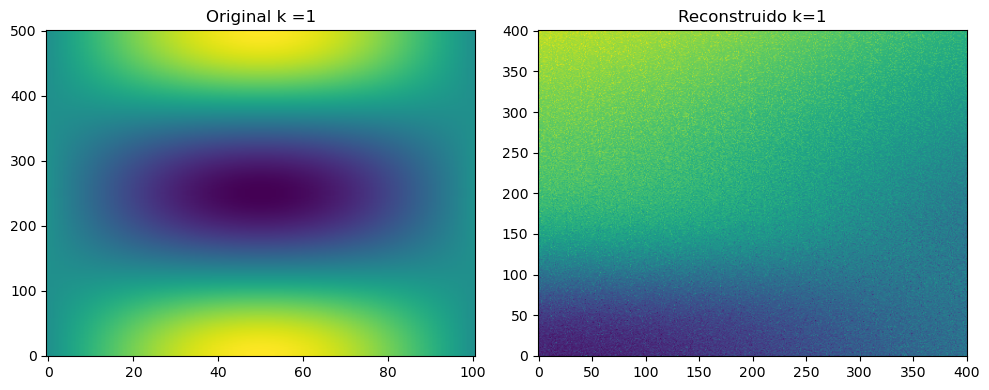

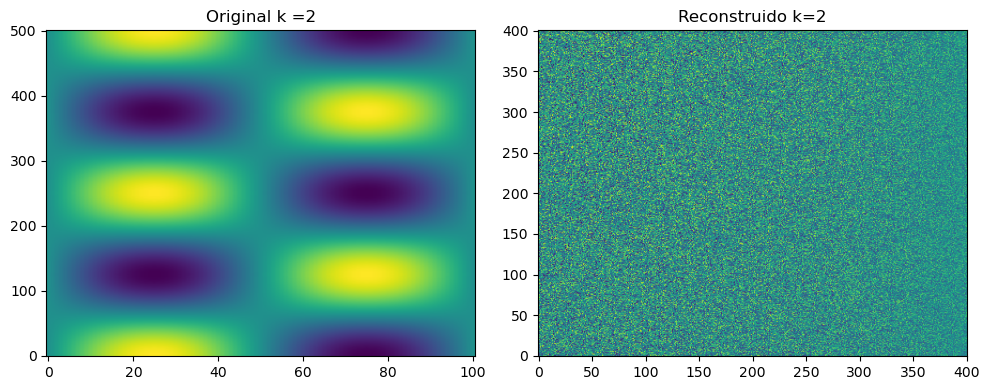

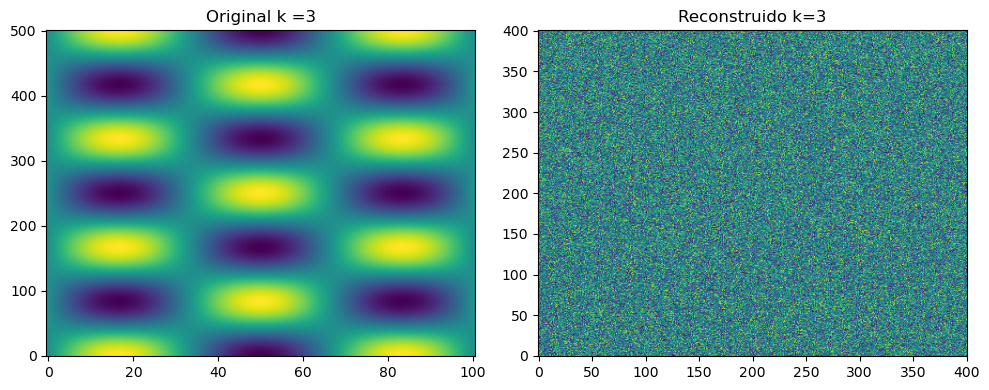

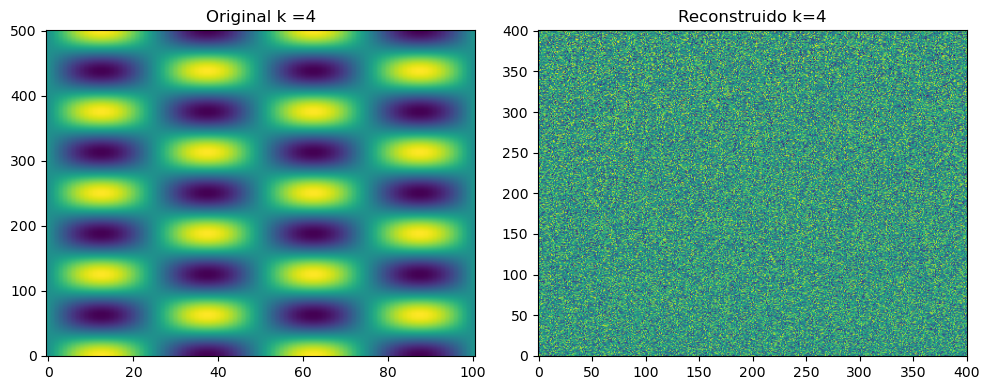

In [30]:
for i in range(1, 5):
    i = str(i)
    pred, true = reconstruct(
        root / f"u_wave_k{i}.pt",
        root / f"flow_models/u_wave_k{i}.fm.pt",
        N=401,
        steps=1000,
    )
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original k ={i}")
    plt.imshow(true.cpu(), origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title("Reconstruido")
    plt.imshow(pred.T.cpu(), origin="lower", aspect="auto")
    plt.title(f"Reconstruido k={i}")
    plt.tight_layout()
    plt.show()